In [ ]:
# # for colab environment
# from google.colab import drive
# !ls /content/drive/MyDrive/projects/ML_FinalProj
# import sys
# import os

# drive.mount('/content/drive')

# sys.path.append('/content/drive/MyDrive/projects/ML_FinalProj')

# os.chdir("/content/drive/MyDrive/projects/ML_FinalProj")

catboost_info		 MLProject_Progress.ipynb     ModelTraining.ipynb
DataPreprocessing.ipynb  MLTeamPredictionBasic.ipynb  Untitled0.ipynb
dataset			 ModelTraining_0941.ipynb     zips
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ROOT = Path("dataset")
TEAM_STAT_PATH = ROOT / "team-stat"
GAME_LOG_PATH = ROOT / "game-log"
PITCHER_PATH = ROOT / "pitcher" / "sp_yearly_game"

DATA_PATH = ROOT / "processed" / "final_dataset_with_diff_v1.csv"

final_df_complete = pd.read_csv(DATA_PATH)


In [ ]:
# Pythagorean expectation 데이터셋에 추가
final_df_complete['home_runs_cum'] = final_df_complete.groupby(['season', 'home_id'])['home_runs'].cumsum()
final_df_complete['home_runs_allowed_cum'] = final_df_complete.groupby(['season', 'home_id'])['away_runs'].cumsum()

final_df_complete['away_runs_cum'] = final_df_complete.groupby(['season', 'away_id'])['away_runs'].cumsum()
final_df_complete['away_runs_allowed_cum'] = final_df_complete.groupby(['season', 'away_id'])['home_runs'].cumsum()

def calc_pythagorean(runs, runs_allowed, exponent=1.83):
    runs = runs.replace(0, 1)
    runs_allowed = runs_allowed.replace(0, 1)
    return (runs ** exponent) / ((runs ** exponent) + (runs_allowed ** exponent))

final_df_complete['home_pyth_win_rate'] = calc_pythagorean(
    final_df_complete['home_runs_cum'].shift(1).fillna(0),
    final_df_complete['home_runs_allowed_cum'].shift(1).fillna(0)
)
final_df_complete['away_pyth_win_rate'] = calc_pythagorean(
    final_df_complete['away_runs_cum'].shift(1).fillna(0),
    final_df_complete['away_runs_allowed_cum'].shift(1).fillna(0)
)

final_df_complete['diff_pyth_win_rate'] = final_df_complete['home_pyth_win_rate'] - final_df_complete['away_pyth_win_rate']

피타고리안 승률 지표 생성 완료


In [ ]:
# train/test set 생성

GLOBAL_RANDOM_SEED = 42

final_df_complete = final_df_complete.sort_values('date').reset_index(drop=True)

split_idx = int(len(final_df_complete) * 0.9)

df_train_val = final_df_complete.iloc[:split_idx]
df_test = final_df_complete.iloc[split_idx:]

print(f"Train Period: {df_train_val['date'].min()} ~ {df_train_val['date'].max()}")
print(f"Test Period : {df_test['date'].min()} ~ {df_test['date'].max()}")

Train Period: 2003-04-09 ~ 2024-04-11
Test Period : 2024-04-11 ~ 2025-10-04


In [ ]:
# Baseline model

# 1. Zero-R Baseline (무조건 홈 승리 예측)
# 테스트 셋의 모든 결과를 홈 승리로 예측
preds_dummy = np.ones(len(df_test))
accuracy_dummy = accuracy_score(df_test['home_win'], preds_dummy)

print(f"\n[Baseline 1: 무조건 홈 승리]")
print(f"Accuracy: {accuracy_dummy:.4f}")

# 2. Simple Rule Baseline (승률 비교)
# 승률 높은 팀이 승리한다고 예측
preds_rule = (df_test['home_in_season_win_rate'] > df_test['away_in_season_win_rate']).astype(int)

accuracy_rule = accuracy_score(df_test['home_win'], preds_rule)

print(f"\n[Baseline 2: 승률 높은 팀 승리]")
print(f"Accuracy: {accuracy_rule:.4f}")




[Baseline 1: 무조건 홈 승리]
Accuracy: 0.4888

[Baseline 2: 승률 높은 팀 승리]
Accuracy: 0.5529


In [ ]:
# Baseline model

# 3. ERA 단순 비교 모델
# 단순 선발 ERA 더 낮은 팀 승리 예측
preds_era_rule = (df_test['home_era'] < df_test['away_era']).astype(int)

accuracy_era_rule = accuracy_score(df_test['home_win'], preds_era_rule)

print(f"\n[Baseline 3: 선발 ERA 더 낮은 팀 승리]")
print(f"Accuracy (정확도): {accuracy_era_rule:.4f}")


# 4. ERA 2개만 사용한 Logistic Regression
X_cols_era = ['home_era', 'away_era']

X_train_era = df_train_val[X_cols_era]
y_train_era = df_train_val['home_win']

X_test_era = df_test[X_cols_era]
y_test_era = df_test['home_win']

# 모델 학습
model_era_lr = LogisticRegression(random_state=GLOBAL_RANDOM_SEED)
model_era_lr.fit(X_train_era, y_train_era)

# 평가
preds_era_lr = model_era_lr.predict(X_test_era)
accuracy_era_lr = accuracy_score(y_test_era, preds_era_lr)

print(f"\n[Baseline 4: ERA Only Logistic Regression]")
print(f"Accuracy (정확도): {accuracy_era_lr:.4f}")


[Baseline 3: 선발 ERA 더 낮은 팀 승리]
Accuracy (정확도): 0.5420

[Baseline 4: ERA Only Logistic Regression]
Accuracy (정확도): 0.5204


In [ ]:
# baseline model
# 단순 평균 타율 높은 팀 선택
preds_bat_rule = (df_test['home_bat_avg'] > df_test['away_bat_avg']).astype(int)
accuracy_bat_rule = accuracy_score(df_test['home_win'], preds_bat_rule)

print(f"\n[Baseline: 타자 평균 타율 더 높은 팀 승리]")
print(f"Accuracy: {accuracy_bat_rule:.4f}")


# 타율 관련 지표(홈/원정 평균 타율, 타율 차이)만 사용하여 학습 logistic regression
bat_features = ['home_bat_avg', 'away_bat_avg', 'diff_bat_avg']

# 학습 데이터 준비
X_train_bat = df_train_val[bat_features]
y_train_bat = df_train_val['home_win']

# 테스트 데이터 준비
X_test_bat = df_test[bat_features]
y_test_bat = df_test['home_win']

# 모델 정의 및 학습
model_bat_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=GLOBAL_RANDOM_SEED))
])

model_bat_lr.fit(X_train_bat, y_train_bat)

# 예측 및 평가
preds_bat_lr = model_bat_lr.predict(X_test_bat)
pred_probs_bat_lr = model_bat_lr.predict_proba(X_test_bat)[:, 1]

accuracy_bat_lr = accuracy_score(y_test_bat, preds_bat_lr)
roc_auc_bat_lr = roc_auc_score(y_test_bat, pred_probs_bat_lr)
logloss_bat_lr = log_loss(y_test_bat, pred_probs_bat_lr)

print(f"\n[Baseline: Batting Average Only Logistic Regression]")
print(f"Accuracy (정확도): {accuracy_bat_lr:.4f}")
print(f"ROC AUC: {roc_auc_bat_lr:.4f}")
print(f"Log Loss: {logloss_bat_lr:.4f}")



[Baseline: 타자 평균 타율 더 높은 팀 승리]
Accuracy: 0.5296

[Baseline: Batting Average Only Logistic Regression]
Accuracy (정확도): 0.5254
ROC AUC: 0.5376
Log Loss: 0.6922


In [ ]:
# baseline model
# 간단한 logistic regression 기반 모델
# 두 팀 간의 차이만을 학습

diff_cols = [col for col in final_df_complete.columns if col.startswith('diff_')]


X_train_base = df_train_val[diff_cols]
y_train_base = df_train_val['home_win']

X_test_base = df_test[diff_cols]
y_test_base = df_test['home_win']

# 모델 정의(logistic regression 이용)
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=GLOBAL_RANDOM_SEED, max_iter=1000))
])

# 모델 학습
baseline_model.fit(X_train_base, y_train_base)

# 모델 평가
preds_base = baseline_model.predict(X_test_base)
pred_probs_base = baseline_model.predict_proba(X_test_base)[:, 1]

accuracy_base = accuracy_score(y_test_base, preds_base)
roc_auc_base = roc_auc_score(y_test_base, pred_probs_base)
logloss_base = log_loss(y_test_base, pred_probs_base)

print(f"\n[Test Set 평가 결과]")
print(f"Accuracy (정확도): {accuracy_base:.4f}")
print(f"ROC AUC: {roc_auc_base:.4f}")
print(f"Log Loss: {logloss_base:.4f}")



[Test Set 평가 결과]
Accuracy (정확도): 0.5221
ROC AUC: 0.5320
Log Loss: 0.6977


In [ ]:
# baseline model
# logistic regression, 이번에는 diff 없는 기본 데이터만 전부 활용
raw_cols = [col for col in final_df_complete.columns if col.startswith('home_') or col.startswith('away_')]

exclude_cols = ['home_win', 'home_runs', 'away_runs', 'home_id', 'away_id', 'year']
X_cols_raw = [c for c in raw_cols if c not in exclude_cols]

print(f"Selected Raw Features: {len(X_cols_raw)} columns")


X_train_raw = df_train_val[X_cols_raw]
y_train_raw = df_train_val['home_win']

X_test_raw = df_test[X_cols_raw]
y_test_raw = df_test['home_win']


baseline_raw_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=GLOBAL_RANDOM_SEED, max_iter=1000))
])


# 4. 모델 학습
baseline_raw_model.fit(X_train_raw, y_train_raw)


# 5. 모델 평가
preds_raw = baseline_raw_model.predict(X_test_raw)
pred_probs_raw = baseline_raw_model.predict_proba(X_test_raw)[:, 1]

accuracy_raw = accuracy_score(y_test_raw, preds_raw)
roc_auc_raw = roc_auc_score(y_test_raw, pred_probs_raw)
logloss_raw = log_loss(y_test_raw, pred_probs_raw)

print(f"\n[Baseline (Raw Data) Test Set 평가 결과]")
print(f"Accuracy (정확도): {accuracy_raw:.4f}")
print(f"ROC AUC: {roc_auc_raw:.4f}")
print(f"Log Loss: {logloss_raw:.4f}")


Selected Raw Features: 282 columns

[Baseline (Raw Data) Test Set 평가 결과]
Accuracy (정확도): 0.5945
ROC AUC: 0.6152
Log Loss: 0.6786


In [ ]:
# XGBoost
# 전체 feature 중 영향력 top-20 feature 선별하여 학습

drop_cols = ['date', 'season', 'home_id', 'away_id', 'home_runs', 'away_runs', 'home_win']
cols_to_drop = [c for c in drop_cols if c in df_train_val.columns]

X_train_val_all = df_train_val.drop(columns=cols_to_drop)
y_train_val_all = df_train_val['home_win']

X_test_new = df_test.drop(columns=cols_to_drop)
y_test_new = df_test['home_win']

X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_val_all,
    y_train_val_all,
    test_size=0.2,
    random_state=GLOBAL_RANDOM_SEED,
    stratify=y_train_val_all
)

# 영향력 확인 위함
model_xgb_all = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=400,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=GLOBAL_RANDOM_SEED
)

model_xgb_all.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)
# 영향력 높은 feature 20개 선택해 새 dataset 정의
booster = model_xgb_all.get_booster()
imp = booster.get_score(importance_type='gain')
if len(imp) > 0 and all(k.startswith('f') for k in imp.keys()):
    name_map = {f"f{i}": n for i, n in enumerate(X_train_xgb.columns)}
    imp_named = {name_map[k]: v for k, v in imp.items() if k in name_map}
else:
    imp_named = imp

imp_series = pd.Series(imp_named, dtype=float).reindex(X_train_xgb.columns).fillna(0.0)
top_features = imp_series.sort_values(ascending=False).head(20).index.tolist()
print(f"Top20 features: {top_features}")

X_train_top = X_train_xgb[top_features]
X_val_top   = X_val_xgb[top_features]
X_test_top  = X_test_new[top_features]
# 선택한 feature 기반 학습
model_xgb_top20 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=GLOBAL_RANDOM_SEED
)
model_xgb_top20.fit(
    X_train_top, y_train_xgb,
    eval_set=[(X_val_top, y_val_xgb)],
    verbose=False
)

preds = model_xgb_top20.predict(X_test_top)
probs = model_xgb_top20.predict_proba(X_test_top)[:, 1]

print("\n[Test Set 평가 결과]")
print(f"Accuracy: {accuracy_score(y_test_new, preds):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test_new, probs):.4f}")
print(f"LogLoss : {log_loss(y_test_new, probs):.4f}")


Top20 features: ['diff_in_season_win_rate', 'diff_타격 RAA_decay', 'away_Own%_decay', 'away_in_season_win_rate', 'diff_wRC+_decay', 'home_R.y_decay', 'diff_wRC_decay', 'home_ERA-_decay', 'away_WAR.x_decay', 'diff_oWAR_decay', 'home_runs_allowed_cum', 'away_RA9_decay', 'away_runs_cum', 'away_runs_allowed_cum', 'home_WAR.x_decay', 'diff_K/BB_decay', 'home_GS_decay', 'away_구원WAR_decay', 'home_IP_decay', 'home_필딩 RAA_decay']

[Test Set 평가 결과]
Accuracy: 0.5729
ROC AUC : 0.6022
LogLoss : 0.6772


In [ ]:
# weighted soft voting
# 투구/타격/수비/이외/해당년도전적 + diff 10개모델
######## ERA, 타율 포함안한모델

drop_cols = ['date', 'season', 'home_id', 'away_id', 'home_runs', 'away_runs', 'home_win']
cols_to_drop = [c for c in drop_cols if c in df_train_val.columns]

X_train_val_all = df_train_val.drop(columns=cols_to_drop)
y_train_val_all = df_train_val['home_win']

X_test_new = df_test.drop(columns=cols_to_drop)
y_test_new = df_test['home_win']

# sub-model 별 feature 목록
offense_base = ['WAR.x_decay', 'oWAR_decay', 'wRC+_decay', 'wOBA_decay', 'OPS_decay', 'wRC_decay', 'AVG.x_decay', 'OBP.x_decay', 'SLG_decay', 'IsoP_decay', 'BB%.x_decay', 'HR.x_decay', 'RBI_decay', 'RC27_decay']
pitching_base = ['WAR.y_decay', '선발WAR_decay', '구원WAR_decay', 'FIP_decay', 'kwERA_decay', 'ERA_decay', 'WHIP_decay', 'K/9_decay', 'BB/9_decay', 'K%.y_decay', 'BB%.y_decay', 'FIP-_decay', 'ERA-_decay', 'LOB_decay', 'HR/9_decay', 'IP_decay', 'GS_decay', 'GR_decay']
defense_base = ['dWAR_decay', '필딩 RAA_decay', 'Range RAA_decay', '수비 RAA_decay', '포지션 RAA_decay', 'E_decay']
others_base = ['Rep.Wins_decay', 'Pos.Wins_decay', 'RAR_decay']
momentum_base = ['in_season_win_rate', 'L10_win_rate']

# Home/Away
offense_features = [f'home_{c}' for c in offense_base] + [f'away_{c}' for c in offense_base]
pitching_features = [f'home_{c}' for c in pitching_base] + [f'away_{c}' for c in pitching_base]
defense_features = [f'home_{c}' for c in defense_base] + [f'away_{c}' for c in defense_base]
others_features = [f'home_{c}' for c in others_base] + [f'away_{c}' for c in others_base]
momentum_features = [f'home_{c}' for c in momentum_base] + [f'away_{c}' for c in momentum_base]
# Diff
diff_offense_features = [f'diff_{c}' for c in offense_base]
diff_pitching_features = [f'diff_{c}' for c in pitching_base]
diff_defense_features = [f'diff_{c}' for c in defense_base]
diff_others_features = [f'diff_{c}' for c in others_base]
diff_momentum_features = [f'diff_{c}' for c in momentum_base]


# sub-model 정의
# 지표별 개별 트리 10개
common_dt_params = {
    'max_depth': 4,
    'min_samples_leaf': 20,
    'random_state': GLOBAL_RANDOM_SEED
}

pipe_offense = Pipeline([('s', ColumnTransformer([('p', 'passthrough', offense_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_pitching = Pipeline([('s', ColumnTransformer([('p', 'passthrough', pitching_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_defense = Pipeline([('s', ColumnTransformer([('p', 'passthrough', defense_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_others = Pipeline([('s', ColumnTransformer([('p', 'passthrough', others_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_momentum = Pipeline([('s', ColumnTransformer([('p', 'passthrough', momentum_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_offense = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_offense_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_pitching = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_pitching_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_defense = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_defense_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_others = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_others_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_momentum = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_momentum_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])


estimators_list = [
    ('offense_tree', pipe_offense),
    ('pitching_tree', pipe_pitching),
    ('defense_tree', pipe_defense),
    ('others_tree', pipe_others),
    ('momentum_tree', pipe_momentum),
    ('diff_offense_tree', pipe_diff_offense),
    ('diff_pitching_tree', pipe_diff_pitching),
    ('diff_defense_tree', pipe_diff_defense),
    ('diff_others_tree', pipe_diff_others),
    ('diff_momentum_tree', pipe_diff_momentum)
]

# 현재는 해당년도 전적에 높은 가중치 들어간 상태
# 조절해 보아도 유의미한 차이는 없었음
manual_weights = [0.05, 0.05, 0.05, 0.05, 0.30, 0.05, 0.05, 0.05, 0.05, 0.30]

# 최종 모델 정의
# soft voting, 수동 가중치
voting_model_manual = VotingClassifier(
    estimators=estimators_list,
    voting='soft',
    weights=manual_weights,
    n_jobs=-1
)

# 학습
voting_model_manual.fit(X_train_val_all, y_train_val_all)

# 모델 평가
preds_manual = voting_model_manual.predict(X_test_new)
pred_probs_manual = voting_model_manual.predict_proba(X_test_new)[:, 1]

accuracy_manual = accuracy_score(y_test_new, preds_manual)
roc_auc_manual = roc_auc_score(y_test_new, pred_probs_manual)
logloss_manual = log_loss(y_test_new, pred_probs_manual)

print(f"\n[Test Set 평가 결과]")
print(f"Accuracy (정확도): {accuracy_manual:.4f}")
print(f"ROC AUC: {roc_auc_manual:.4f}")
print(f"Log Loss: {logloss_manual:.4f}")


[Test Set 평가 결과]
Accuracy (정확도): 0.5454
ROC AUC: 0.5543
Log Loss: 0.6908


In [ ]:
# soft voting
# ERA, 타율 정보 포함

# Feature 정의
era_features_home = ['home_era']
era_features_away = ['away_era']
era_features_diff = ['diff_era']

bat_features_home = ['home_bat_avg']
bat_features_away = ['away_bat_avg']
bat_features_diff = ['diff_bat_avg']


# Pipeline 생성
pipe_home_era = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', era_features_home)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])
pipe_away_era = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', era_features_away)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])
pipe_diff_era = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', era_features_diff)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])

pipe_home_bat = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', bat_features_home)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])
pipe_away_bat = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', bat_features_away)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])
pipe_diff_bat = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', bat_features_diff)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])


estimators_list_final = estimators_list + [
    ('home_era_tree', pipe_home_era),
    ('away_era_tree', pipe_away_era),
    ('diff_era_tree', pipe_diff_era),
    ('home_bat_tree', pipe_home_bat),
    ('away_bat_tree', pipe_away_bat),
    ('diff_bat_tree', pipe_diff_bat)
]

# 4. 가중치 재설정
final_weights = [
    0.02, 0.02, 0.02, 0.02, 0.1,
    0.02, 0.02, 0.02, 0.02, 0.1,
    0.3, 0.3, 0.3,
    0.05, 0.05, 0.15
]


# 모델 학습 및 평가
voting_model_final = VotingClassifier(
    estimators=estimators_list_final,
    voting='soft',
    weights=final_weights,
    n_jobs=-1
)

voting_model_final.fit(X_train_val_all, y_train_val_all)

# 평가
preds_final = voting_model_final.predict(X_test_new)
pred_probs_final = voting_model_final.predict_proba(X_test_new)[:, 1]

accuracy_final = accuracy_score(y_test_new, preds_final)
roc_auc_final = roc_auc_score(y_test_new, pred_probs_final)
logloss_final = log_loss(y_test_new, pred_probs_final)

print(f"\n[Test Set 평가 결과]")
print(f"Accuracy (정확도): {accuracy_final:.4f}")
print(f"ROC AUC: {roc_auc_final:.4f}")
print(f"Log Loss: {logloss_final:.4f}")


[Test Set 평가 결과]
Accuracy (정확도): 0.5187
ROC AUC: 0.5714
Log Loss: 0.6897


Training Bagging Models with 412 features...

[Model 1: Custom Bagging Classifier]
Accuracy: 0.5429
ROC AUC : 0.5701

[Model 2: Random Forest]
Accuracy: 0.5154
ROC AUC : 0.5269
Log Loss: 0.6957


/tmp/ipython-input-4253860762.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_imp.values, y=top_20_imp.index, palette='viridis')


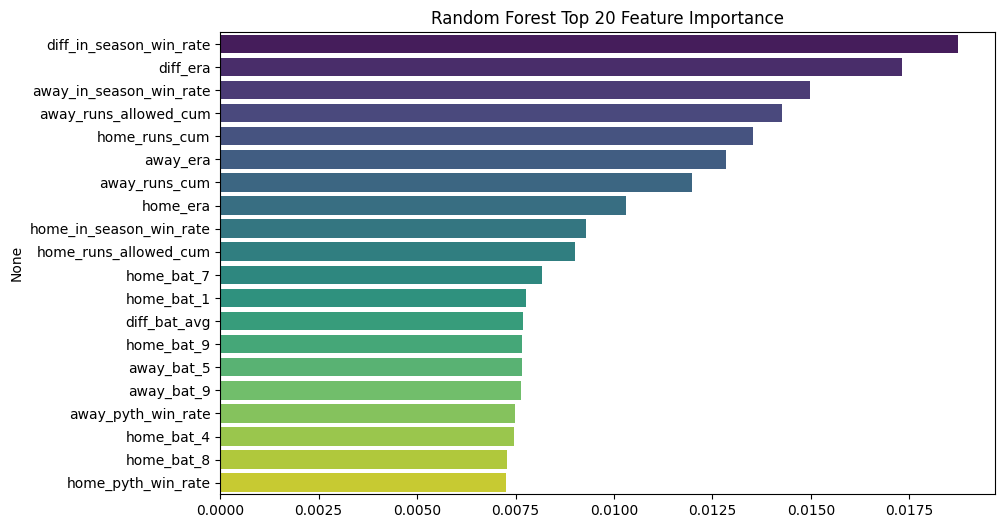

In [ ]:
# custom bagging + random forest

drop_cols = ['date', 'season', 'year', 'home_id', 'away_id', 'home_runs', 'away_runs', 'home_win']
cols_to_drop = [c for c in drop_cols if c in df_train_val.columns]

X_train_bag = df_train_val.drop(columns=cols_to_drop)
y_train_bag = df_train_val['home_win']

X_test_bag = df_test.drop(columns=cols_to_drop)
y_test_bag = df_test['home_win']

# 결측치처리
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_bag = pd.DataFrame(imputer.fit_transform(X_train_bag), columns=X_train_bag.columns)
X_test_bag = pd.DataFrame(imputer.transform(X_test_bag), columns=X_test_bag.columns)

print(f"Training Bagging Models with {X_train_bag.shape[1]} features...")


# custom bagging
#  학습 데이터의 70%만 무작위로 뽑아서 각 트리를 학습 (다양성 확보)
#  Feature의 80%만 무작위로 뽑아서 학습 (Feature Bagging)
#  100개의 트리를 만들어 voting

bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, min_samples_leaf=10), # 너무 깊지 않은 트리 (Overfitting 방지)
    n_estimators=100,
    max_samples=0.7,   # Row Sampling (Bootstrap)
    max_features=0.8,  # Column Sampling (Feature Bagging)
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=-1,
    random_state=42
)

# 학습
bagging_model.fit(X_train_bag, y_train_bag)

# 평가
preds_bag = bagging_model.predict(X_test_bag)
probs_bag = bagging_model.predict_proba(X_test_bag)[:, 1]

print(f"\n[Model 1: Custom Bagging Classifier]")
print(f"Accuracy: {accuracy_score(y_test_bag, preds_bag):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test_bag, probs_bag):.4f}")



#### random forest


rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# 학습
rf_model.fit(X_train_bag, y_train_bag)

# 평가
preds_rf = rf_model.predict(X_test_bag)
probs_rf = rf_model.predict_proba(X_test_bag)[:, 1]

print(f"\n[Model 2: Random Forest]")
print(f"Accuracy: {accuracy_score(y_test_bag, preds_rf):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test_bag, probs_rf):.4f}")
print(f"Log Loss: {log_loss(y_test_bag, probs_rf):.4f}")

# Feature Importance 확인 (Random Forest)

imp_series = pd.Series(rf_model.feature_importances_, index=X_train_bag.columns)
top_20_imp = imp_series.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_imp.values, y=top_20_imp.index, palette='viridis')
plt.title('Random Forest Top 20 Feature Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# stacking ensemble
from sklearn.ensemble import HistGradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=200,
    max_depth=5,
    l2_regularization=0.1,
    random_state=42
)


mlp_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
)

estimators = [
    ('bagging', bagging_model),
    ('rf', rf_model),
    ('hgb', hgb_model),
    ('mlp', mlp_model)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    cv=5
)

stacking_model.fit(X_train_bag, y_train_bag)

# 평가
preds_stack = stacking_model.predict(X_test_bag)
probs_stack = stacking_model.predict_proba(X_test_bag)[:, 1]

print(f"Accuracy: {accuracy_score(y_test_bag, preds_stack):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test_bag, probs_stack):.4f}")
print(f"Log Loss: {log_loss(y_test_bag, probs_stack):.4f}")

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Accuracy: 0.5770
ROC AUC : 0.6122
Log Loss: 0.6750


In [ ]:
# parameter tuning
# !pip install optuna # for colab environment

import optuna

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)

    # Validation Set에 대한 LogLoss를 최소화
    preds = model.predict_proba(X_val_xgb)[:, 1]
    return log_loss(y_val_xgb, preds)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.1 MB/s eta 0:00:00


[I 2025-12-10 06:49:06,507] A new study created in memory with name: no-name-febe3038-07eb-4145-8e79-cd60b55ce038
[I 2025-12-10 06:50:08,826] Trial 0 finished with value: 0.8475082882192626 and parameters: {'n_estimators': 524, 'learning_rate': 0.22629518386367492, 'max_depth': 5, 'subsample': 0.8567828829066542, 'colsample_bytree': 0.913042652679037, 'reg_alpha': 1.2719444595062523, 'reg_lambda': 9.58730491795869}. Best is trial 0 with value: 0.8475082882192626.
[I 2025-12-10 06:51:05,918] Trial 1 finished with value: 0.8028488346167005 and parameters: {'n_estimators': 757, 'learning_rate': 0.17534740307948143, 'max_depth': 4, 'subsample': 0.6143010710619508, 'colsample_bytree': 0.9694805127314461, 'reg_alpha': 2.5981780766570006, 'reg_lambda': 9.58299812200079}. Best is trial 1 with value: 0.8028488346167005.
[I 2025-12-10 06:51:58,925] Trial 2 finished with value: 0.6993722985188585 and parameters: {'n_estimators': 591, 'learning_rate': 0.05067015175029963, 'max_depth': 5, 'subsampl

Best params: {'n_estimators': 515, 'learning_rate': 0.05173468393802391, 'max_depth': 3, 'subsample': 0.9048241755708284, 'colsample_bytree': 0.9009480524592707, 'reg_alpha': 0.8678097623640972, 'reg_lambda': 2.402287702767269}


In [ ]:
# xgb model with tuned parameter
best_xgb_params = {
    'n_estimators': 515,
    'learning_rate': 0.05173468393802391,
    'max_depth': 3,
    'subsample': 0.9048241755708284,
    'colsample_bytree': 0.9009480524592707,
    'reg_alpha': 0.8678097623640972,
    'reg_lambda': 2.402287702767269,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': GLOBAL_RANDOM_SEED,
    'n_jobs': -1
}

model_xgb_opt = xgb.XGBClassifier(**best_xgb_params)

print("Training XGBoost with optimized parameters...")
model_xgb_opt.fit(
    X_train_xgb,
    y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)

preds_opt = model_xgb_opt.predict(X_test_new)
probs_opt = model_xgb_opt.predict_proba(X_test_new)[:, 1]

accuracy_opt = accuracy_score(y_test_new, preds_opt)
roc_auc_opt = roc_auc_score(y_test_new, probs_opt)
logloss_opt = log_loss(y_test_new, probs_opt)

print(f"Accuracy (정확도): {accuracy_opt:.4f}")
print(f"ROC AUC: {roc_auc_opt:.4f}")
print(f"Log Loss: {logloss_opt:.4f}")

Training XGBoost with optimized parameters...
Accuracy (정확도): 0.5912
ROC AUC: 0.6193
Log Loss: 0.6704
